The initial and trained models below can be found on kaggle:

- Robin-ResNet50 https://www.kaggle.com/models/bahiskaraananda/robin-resnet50/

In [1]:
%pip install tensorflow==2.15

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 475.2/475.2 MB 3.2 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 46.8 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 30.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 73.9 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 3.5 MB/s eta 0:00:00
  Attempting uninstall: wrapt
    Found existing installation: wrapt 1.16.0
    Uninstalling wrapt-1.16.0:
      Successfully uninstalled wrapt-1.16.0
  Attempting uninstall: ml-dtypes
    Found existing installation: ml-dtypes 0.3.2
    Uninstalling ml-dtypes-0.3.2:
      Successfully uninstalled ml-dtypes-0.3.2
  Attempting uninstall: keras
    Found existing installation: keras 3.3.3
    Uninstalling keras-3.3.3:
      Successfully uninstalled keras-3.3.3
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.16.2
    Uninstalling tensorboard-2.16.2:


# Importing libraries

In [2]:
import tensorflow as tf
import keras
import sklearn
print("TensorFlow:", tf.__version__)
print("Keras:", keras.__version__)
print("scikit-learn:", sklearn.__version__)

2024-11-22 05:10:55.813326: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-11-22 05:10:55.813422: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-22 05:10:55.815879: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


TensorFlow: 2.15.0
Keras: 2.15.0
scikit-learn: 1.2.2


In [4]:
import warnings
warnings.filterwarnings('ignore')

import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.layers import Input, Activation, Add, Dense, Conv2D, GlobalAveragePooling2D, MaxPooling2D
from keras.layers import BatchNormalization, Dropout
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
from keras.models import Model
from keras.utils import plot_model
from tensorflow.keras.models import load_model
from sklearn.metrics import classification_report, confusion_matrix

 # Setting up dataset paths

In [37]:
dataset_path = '/kaggle/input/robin-base'
dataset_class = os.listdir(dataset_path)

train_dir = '/kaggle/input/robin-base/train'
val_dir = '/kaggle/input/robin-base/val'
test_dir = '/kaggle/input/robin-base/test'

In [38]:
for split_dir in [train_dir, val_dir, test_dir]:
    print(f"Contents of {split_dir}:")
    for class_dir in os.listdir(split_dir):
        class_path = os.path.join(split_dir, class_dir)
        if os.path.isdir(class_path):
            print(f" - Class: {class_dir}, Number of images: {len(os.listdir(class_path))}")

Contents of /kaggle/input/robin-base/train:
 - Class: elektronik, Number of images: 2099
 - Class: logam, Number of images: 2099
 - Class: plastik, Number of images: 2099
 - Class: buah_sayuran, Number of images: 2099
 - Class: makanan, Number of images: 2099
 - Class: daun, Number of images: 2099
 - Class: tekstil, Number of images: 2099
 - Class: medis, Number of images: 2099
 - Class: kaca, Number of images: 2099
 - Class: kertas, Number of images: 2099
Contents of /kaggle/input/robin-base/val:
 - Class: elektronik, Number of images: 600
 - Class: logam, Number of images: 600
 - Class: plastik, Number of images: 600
 - Class: buah_sayuran, Number of images: 600
 - Class: makanan, Number of images: 600
 - Class: daun, Number of images: 600
 - Class: tekstil, Number of images: 600
 - Class: medis, Number of images: 600
 - Class: kaca, Number of images: 600
 - Class: kertas, Number of images: 600
Contents of /kaggle/input/robin-base/test:
 - Class: elektronik, Number of images: 301
 - 

In [40]:
data = []

for class_name in dataset_class:
    for file in os.listdir(os.path.join(dataset_path, class_name)):
        data.append((os.path.join(dataset_path, class_name, file), class_name))

df = pd.DataFrame(data, columns=['filepath', 'label'])
df.head()

,filepath,label
0,/kaggle/input/robin-base/val/elektronik,val
1,/kaggle/input/robin-base/val/logam,val
2,/kaggle/input/robin-base/val/plastik,val
3,/kaggle/input/robin-base/val/buah_sayuran,val
4,/kaggle/input/robin-base/val/makanan,val


# Image preprocessing and augmentation

In [41]:
train_datagen = ImageDataGenerator(
    rotation_range=60,                       # Randomly rotate by up to 60 degrees
    width_shift_range=0.15,                  # Randomly shift horizontally by up to 15% of the width
    height_shift_range=0.15,                 # Randomly shift vertically by up to 15% of the height
    zoom_range=0.20,                         # Randomly zoom in or out by up to 20%
    horizontal_flip=True,                    # Randomly flip horizontally
    vertical_flip=True,                      # Randomly flip vertically
    shear_range=0.05,                        # Apply slight shear transformations
    brightness_range=[0.9, 1.1],             # Vary brightness between 90% to 110%
    channel_shift_range=10,                  # Randomly shift channels
    fill_mode='nearest',                     # Fill in missing pixels with the nearest value
    preprocessing_function=preprocess_input
)

val_test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

In [42]:
train_generator = train_datagen.flow_from_directory(
    directory=train_dir,
    target_size=(224, 224),
    batch_size=64,
    class_mode='categorical',
    seed=42
)

val_generator = val_test_datagen.flow_from_directory(
    directory=val_dir,
    target_size=(224, 224),
    batch_size=64,
    class_mode='categorical',
    seed=42
)

test_generator = val_test_datagen.flow_from_directory(
    directory=test_dir,
    target_size=(224, 224),
    batch_size=64,
    class_mode='categorical',
    shuffle=False,
    seed=42
)

Found 20990 images belonging to 10 classes.
Found 6000 images belonging to 10 classes.
Found 3010 images belonging to 10 classes.


In [43]:
print(f"Number of batches in train_generator: {len(train_generator)}")
print(f"Number of batches in val_generator: {len(val_generator)}")

Number of batches in train_generator: 328
Number of batches in val_generator: 94


In [44]:
train_generator.class_indices

{'buah_sayuran': 0,
 'daun': 1,
 'elektronik': 2,
 'kaca': 3,
 'kertas': 4,
 'logam': 5,
 'makanan': 6,
 'medis': 7,
 'plastik': 8,
 'tekstil': 9}

#  Loading the previous trained model

In [13]:
model_path = "/kaggle/input/robin-resnet50/keras/1.0-23m/1/robin.keras"
robin = load_model(model_path)

In [19]:
#recompile model
robin.compile(optimizer=Adam(learning_rate=0.00001), loss='categorical_crossentropy', metrics=['accuracy'])

In [20]:
from keras.callbacks import ModelCheckpoint

In [21]:
checkpoint = ModelCheckpoint(
    'robin_50.keras',
    monitor='val_loss',
    save_best_only=True, 
    mode='min',
    verbose=1 
)

callbacks = [
    checkpoint,
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=0.000001),
    EarlyStopping(monitor='val_loss', mode='min', patience=15, restore_best_weights=True, verbose=1)
]

# Continue training from the initial epoch

In [22]:
history = robin.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    validation_data=val_generator,
    validation_steps=len(val_generator),
    epochs=50,              
    initial_epoch=10, 
    callbacks=callbacks
)

Epoch 11/50
328/328 [==============================] - ETA: 0s - loss: 0.0746 - accuracy: 0.9760
Epoch 11: val_loss improved from inf to 0.29998, saving model to robin_50.keras
328/328 [==============================] - 414s 1s/step - loss: 0.0746 - accuracy: 0.9760 - val_loss: 0.3000 - val_accuracy: 0.9337 - lr: 1.0000e-05
Epoch 12/50
328/328 [==============================] - ETA: 0s - loss: 0.0567 - accuracy: 0.9808
Epoch 12: val_loss improved from 0.29998 to 0.28807, saving model to robin_50.keras
328/328 [==============================] - 313s 955ms/step - loss: 0.0567 - accuracy: 0.9808 - val_loss: 0.2881 - val_accuracy: 0.9328 - lr: 1.0000e-05
Epoch 13/50
328/328 [==============================] - ETA: 0s - loss: 0.0497 - accuracy: 0.9832
Epoch 13: val_loss did not improve from 0.28807
328/328 [==============================] - 309s 942ms/step - loss: 0.0497 - accuracy: 0.9832 - val_loss: 0.2968 - val_accuracy: 0.9308 - lr: 1.0000e-05
Epoch 14/50
328/328 [=======================

The model val loss improved until epoch 12 (lowest: 0.28807) but stopped improving afterward, indicating overfitting despite increasing training accuracy. Early stopping was triggered at epoch 27, and the model weights restored to epoch 12 for the best validation performance.

# Learning curves and model performance

In [28]:
def plot_learning_curves(history, start_epoch=5):
    """
    Plot training and validation loss and accuracy curves.

    Parameters:
    - history: Training history (output from the model's fit method).
    - start_epoch: Epoch from which to start plotting. Default is 5 (i.e., plot from epoch 6 onwards).
    """
    
    df = pd.DataFrame(history.history)
    df = df.iloc[start_epoch-1:]
    sns.set(rc={'axes.facecolor': '#f0f0fc'}, style='darkgrid')
    
    plt.figure(figsize=(15,6))
    plt.subplot(1, 2, 1)
    sns.lineplot(x=df.index, y=df['loss'], color='royalblue', label='Train Loss')
    sns.lineplot(x=df.index, y=df['val_loss'], color='orangered', linestyle='--', label='Validation Loss')
    plt.title('Loss Evolution')
    plt.subplot(1, 2, 2)
    sns.lineplot(x=df.index, y=df['accuracy'], color='royalblue', label='Train Accuracy')
    sns.lineplot(x=df.index, y=df['val_accuracy'], color='orangered', linestyle='--', label='Validation Accuracy')
    plt.title('Accuracy Evolution')

    plt.show()

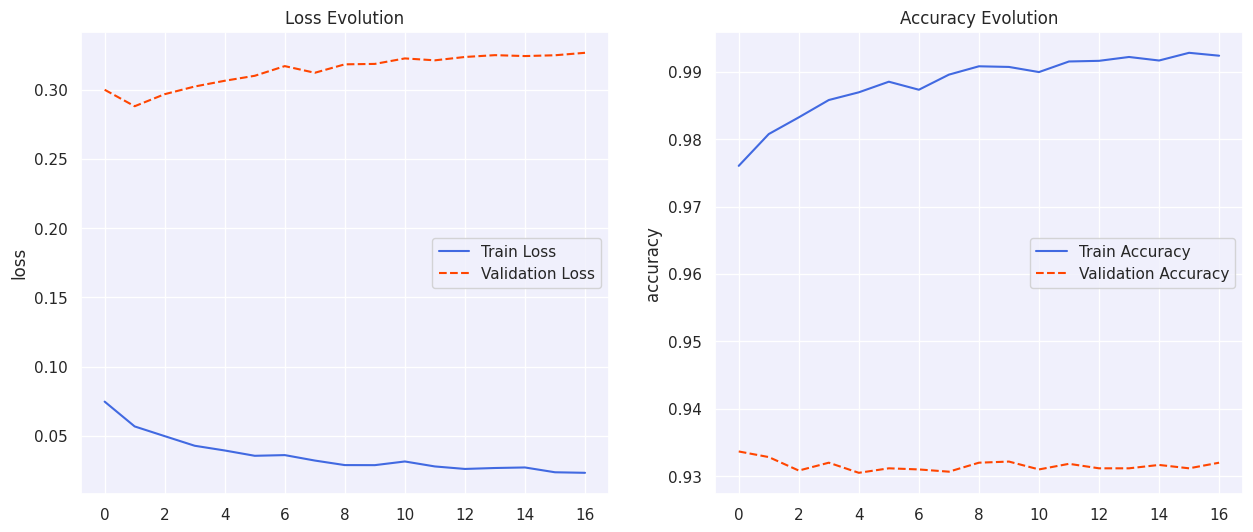

In [29]:
plot_learning_curves(history, start_epoch=1)

In [30]:
def evaluate_model_performance(model, val_generator, class_labels):
    """
    Evaluate the model's performance on the validation set and print the classification report.

    Parameters:
    - model: The trained model.
    - val_generator: Validation data generator.
    - class_labels: List of class names.
    
    Returns:
    - report: Classification report as a string.
    """
    
    true_labels = val_generator.classes
    class_labels = list(val_generator.class_indices.keys()) 
    predictions = model.predict(val_generator, steps=len(val_generator))
    predicted_labels = np.argmax(predictions, axis=1)
    true_labels = val_generator.classes
    report = classification_report(true_labels, predicted_labels, target_names=class_labels)
    print(report)
    print('\n')
    
    colors = ["white", "royalblue"]
    cmap_cm = LinearSegmentedColormap.from_list("cmap_cm", colors)
    cm = confusion_matrix(true_labels, predicted_labels)

    plt.figure(figsize=(8,6))
    sns.heatmap(cm, annot=True, cmap=cmap_cm, fmt='d', xticklabels=class_labels, yticklabels=class_labels)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.show()

48/48 [==============================] - 24s 492ms/step
              precision    recall  f1-score   support

buah_sayuran       0.89      0.89      0.89       301
        daun       0.96      0.96      0.96       301
  elektronik       0.99      0.95      0.97       301
        kaca       0.90      0.94      0.92       301
      kertas       0.94      0.93      0.93       301
       logam       0.91      0.93      0.92       301
     makanan       0.90      0.93      0.92       301
       medis       0.93      0.93      0.93       301
     plastik       0.88      0.87      0.87       301
     tekstil       0.99      0.97      0.98       301

    accuracy                           0.93      3010
   macro avg       0.93      0.93      0.93      3010
weighted avg       0.93      0.93      0.93      3010





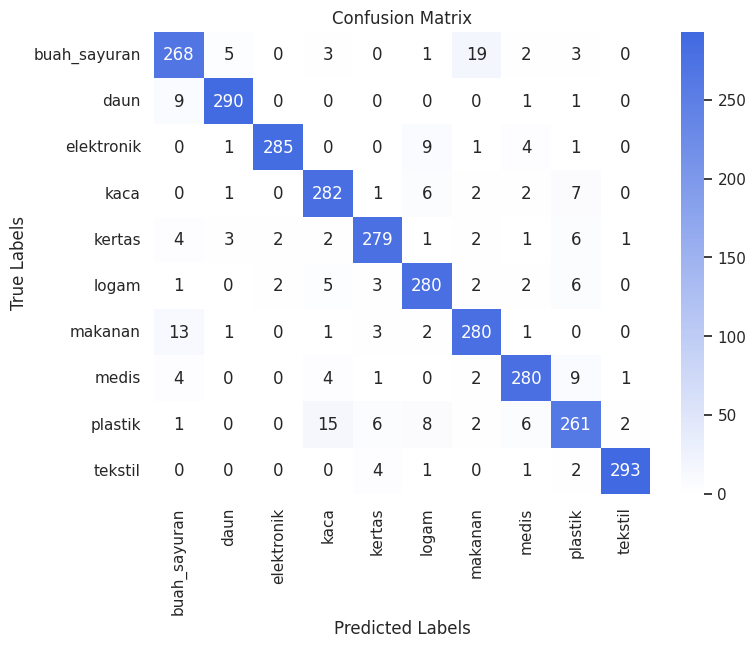

In [31]:
class_labels = list(test_generator.class_indices.keys())
evaluate_model_performance(robin, test_generator, class_labels)

The model performance at epoch 12 showed minimal improvement compared to epoch 10. Test accuracy remained constant at 93%, and class-level metrics, such as precision, recall, and F1-scores, showed slight fluctuations within 1-2%. This indicates that the model performance plateaued, with no significant changes despite further training.

# Testing the model

In [7]:
new_model_path = "/kaggle/input/robin-resnet50/keras/1.1-23m/1/robin_50.keras"
robin = load_model(new_model_path)

In [50]:
def plot_random_predictions(model, test_generator, class_labels, num_images=9, seed=None):
    """
    Plot a grid of random predictions for test images from the generator.

    Parameters:
    - model: The trained model.
    - test_generator: Test data generator.
    - class_labels: List of class names.
    - num_images: Number of images to display (default is 9 for a 3x3 grid).
    - seed: Random seed for reproducibility (default is None for different random selections).
    """

    if seed is not None:
        np.random.seed(seed)

    test_images, test_labels = next(test_generator)
    predictions = model.predict(test_images)
    predicted_classes = np.argmax(predictions, axis=1)
    true_classes = np.argmax(test_labels, axis=1)
    indices = np.random.choice(len(test_images), num_images, replace=False)

    fig, axes = plt.subplots(3, 3, figsize=(10, 10))
    fig.subplots_adjust(hspace=0.5, wspace=0.5)

    for i, ax in enumerate(axes.flat):
        if i >= len(indices):
            break
        idx = indices[i]
        ax.imshow(test_images[idx].astype("uint8"))
        ax.axis('off')

        true_label = class_labels[true_classes[idx]]
        predicted_label = class_labels[predicted_classes[idx]]

        color = 'green' if true_label == predicted_label else 'red'
        ax.set_title(f"True: {true_label}\nPred: {predicted_label}", color=color)

    plt.show()


In [51]:
class_labels = list(test_generator.class_indices.keys())

2/2 [==============================] - 6s 3s/step


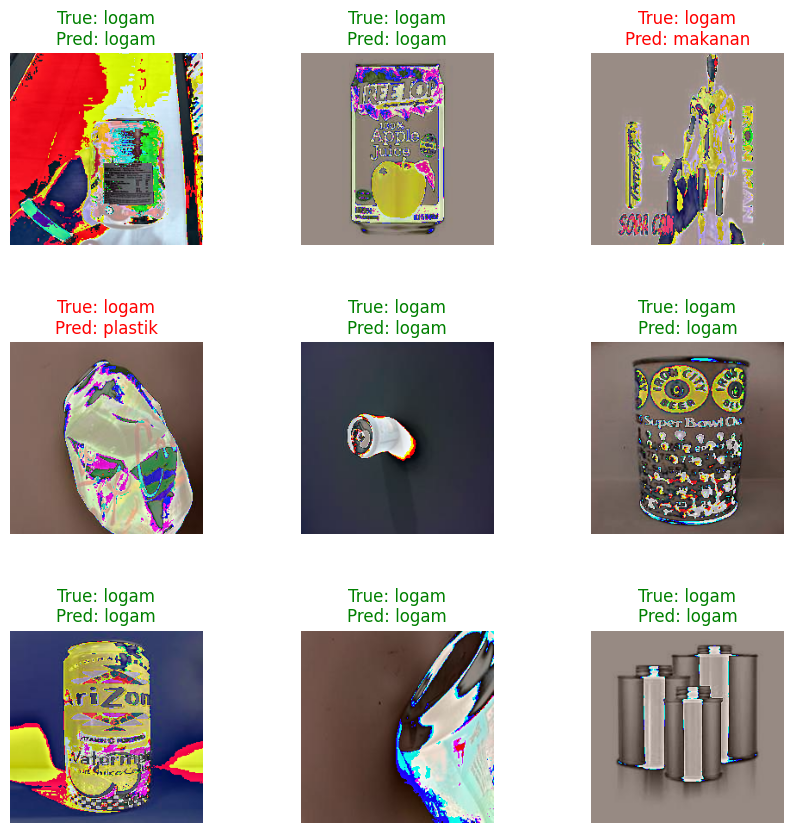

In [77]:
plot_random_predictions(robin, test_generator, class_labels, seed=4096)

2/2 [==============================] - 6s 3s/step


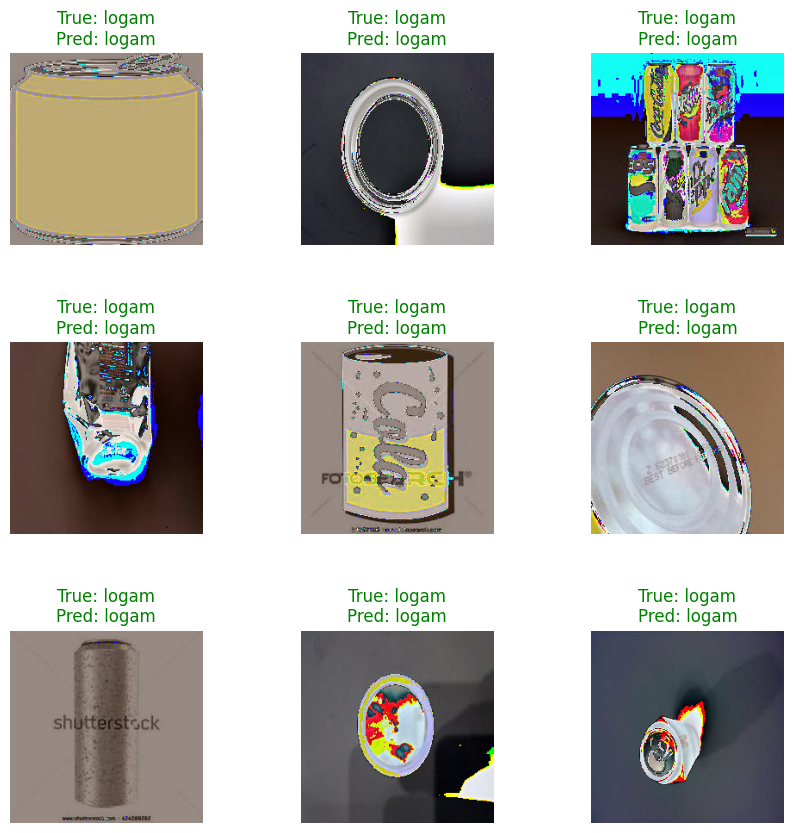

In [78]:
plot_random_predictions(robin, test_generator, class_labels, seed=4096)

2/2 [==============================] - 6s 3s/step


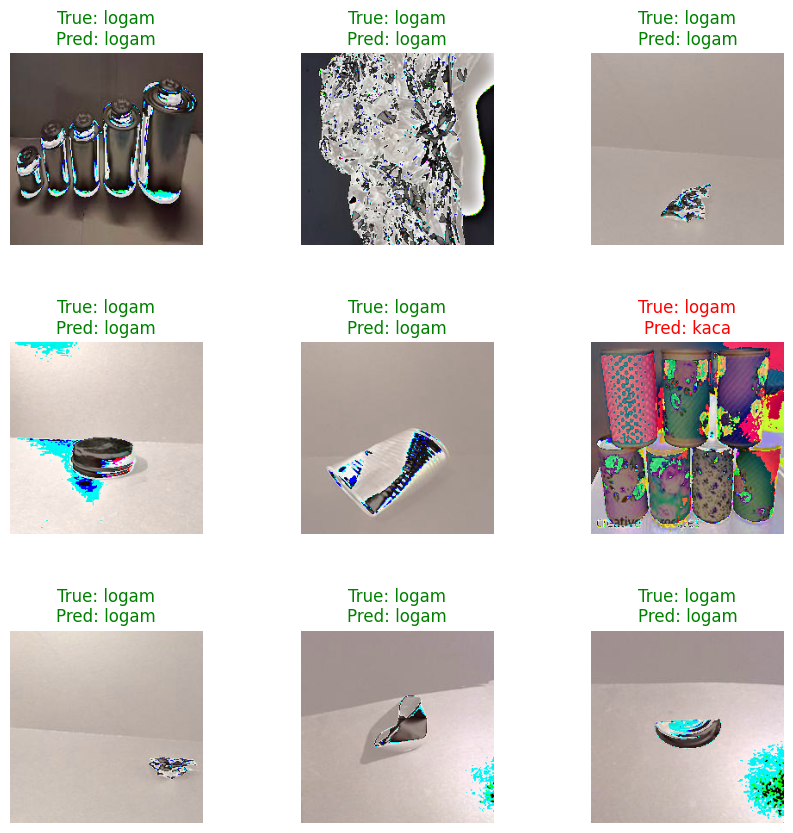

In [79]:
plot_random_predictions(robin, test_generator, class_labels, seed=4096)

2/2 [==============================] - 6s 3s/step


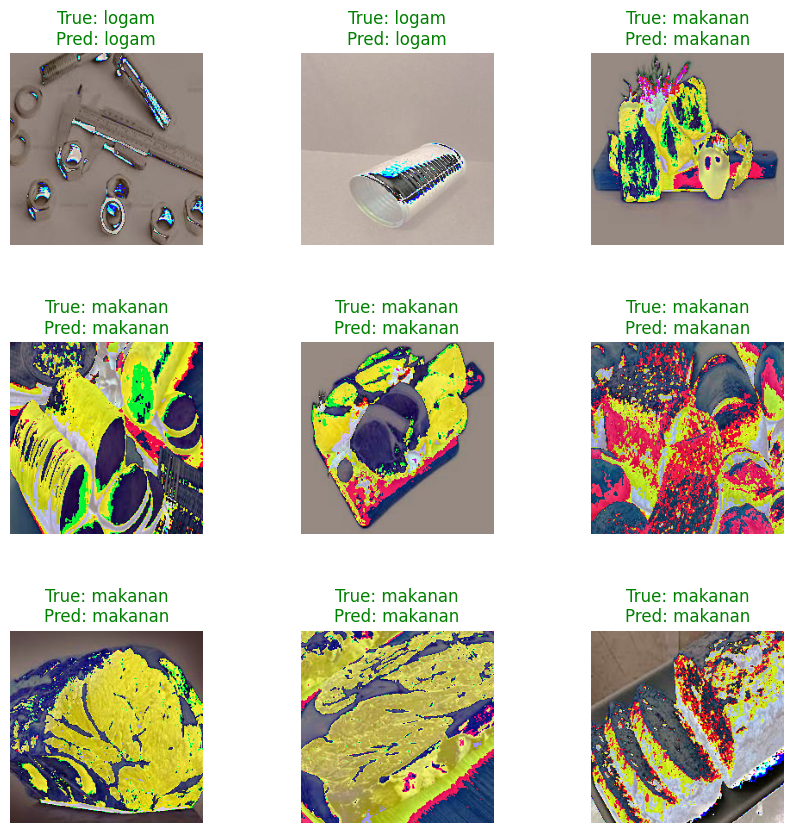

In [80]:
plot_random_predictions(robin, test_generator, class_labels, seed=4096)

2/2 [==============================] - 6s 3s/step


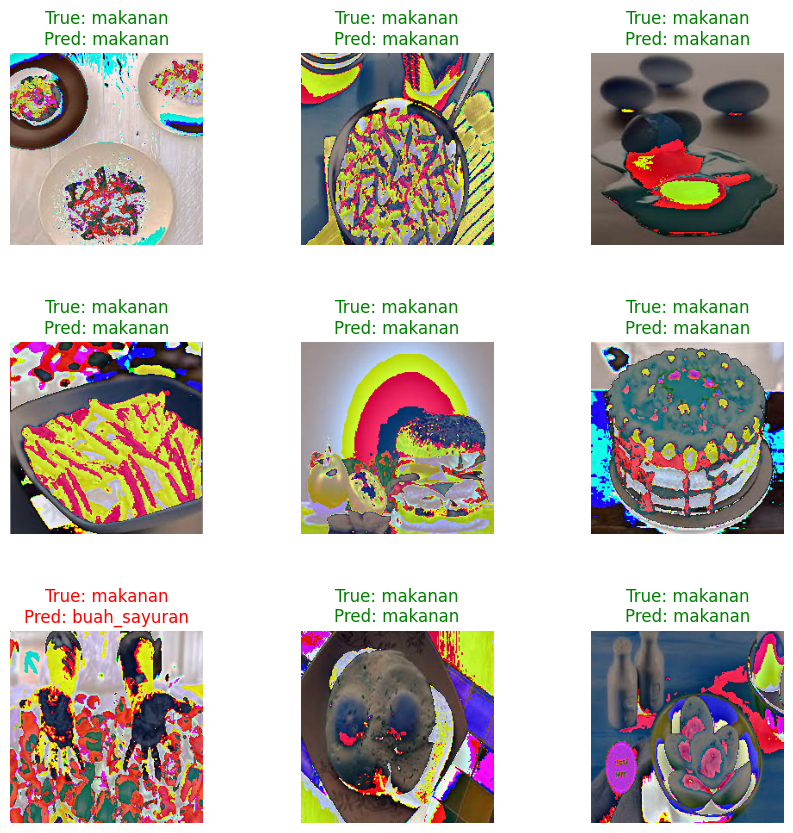

In [82]:
plot_random_predictions(robin, test_generator, class_labels, seed=4096)